In [1]:
import warnings
warnings.filterwarnings('ignore')

import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [2]:
plt.rcParams['figure.figsize'] = (15, 9)

# Image Classification

With this one-line code, we can load a pre-trained **ResNet50_v1** model for classification.

In [3]:
ctx = mx.gpu(0)
net = gcv.model_zoo.resnet50_v1b(pretrained=True, ctx=ctx)

Model file is not found. Downloading.


100%|██████████| 55344/55344 [00:03<00:00, 14727.68KB/s]


With another one-line code we can have our prediction.

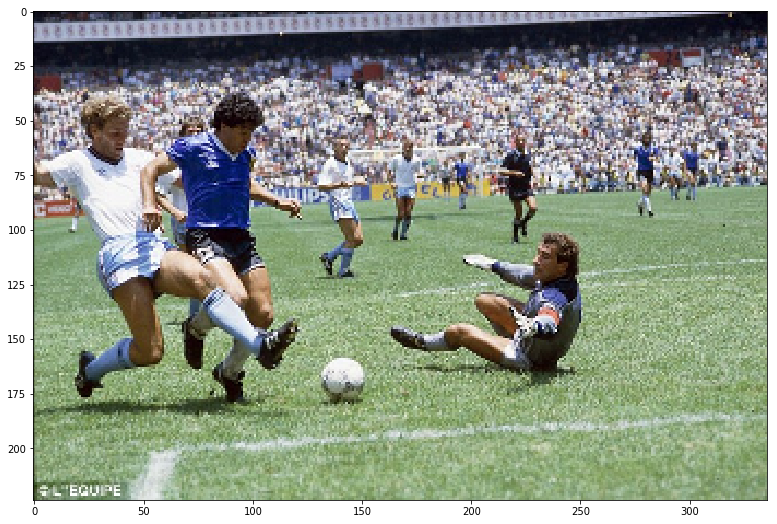

In [4]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/goal.jpg', short=224)
viz.plot_image(img)

In [5]:
%%time
pred = net(x.as_in_context(ctx))

CPU times: user 24.3 ms, sys: 7.76 ms, total: 32.1 ms
Wall time: 16.4 ms


Let's review the top 5 prediction results.

In [7]:
classes_fname = download('https://raw.githubusercontent.com/hetong007/gluon-cv/master/scripts/classification/imagenet/imagenet_labels.txt',
                         'imagenet_labels.txt')
with open('imagenet_labels.txt', 'r') as f:
    class_names = [l.strip('\n') for l in f.readlines()]

6KB [00:00, 2944.40KB/s]             

In [8]:
topK = 5
ind = pred.topk(k=topK).astype('int')[0]
for i in range(topK):
    print('[%s], with probability %.1f%%'%
         (class_names[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()*100))

[soccer_ball], with probability 47.5%
[rugby_ball], with probability 22.9%
[football_helmet], with probability 6.2%
[ballplayer], with probability 1.7%
[baseball], with probability 1.1%


# Object Detection

Image classifications are trained to recognize the main object in the scene. What if we have multiple subjects?

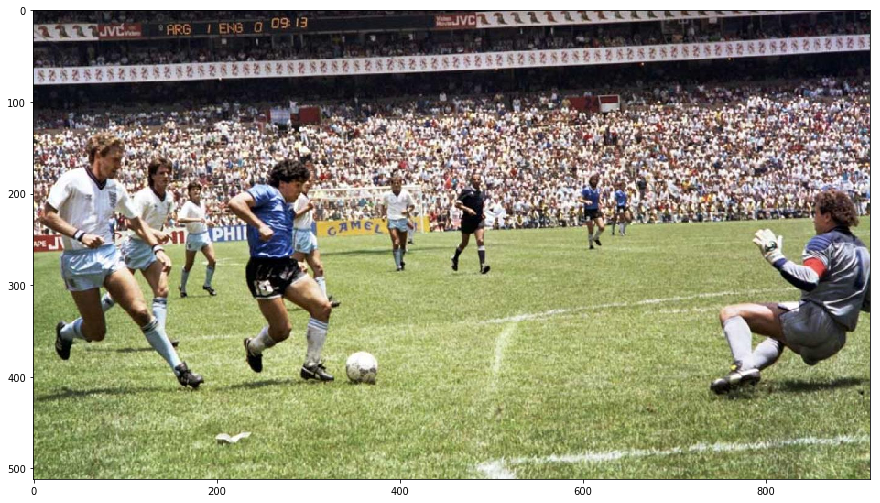

In [9]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/diego.jpg', short=512)
viz.plot_image(img)
plt.show()

We can instead predict with an object detection model **SSD**.
![](support/ssd.png)
![](https://i.stack.imgur.com/Z3cIS.png)

In [10]:
ctx = mx.gpu(1)
net = get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

Model file is not found. Downloading.


181189KB [00:04, 44206.23KB/s]                            


Now we predict. Notice we have three output variables.

In [11]:
%%time
class_IDs, scores, bounding_boxes = net(x.as_in_context(ctx))

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 26.1 ms


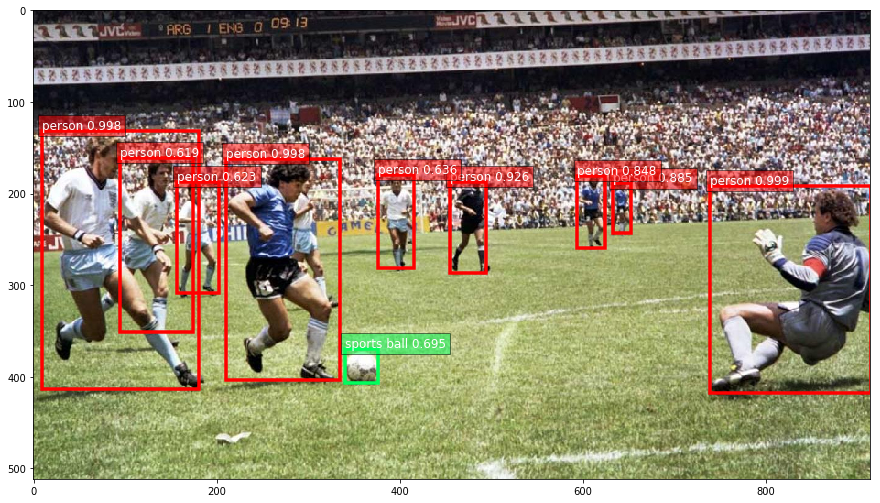

In [12]:
viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

How about we count how many people are here today?

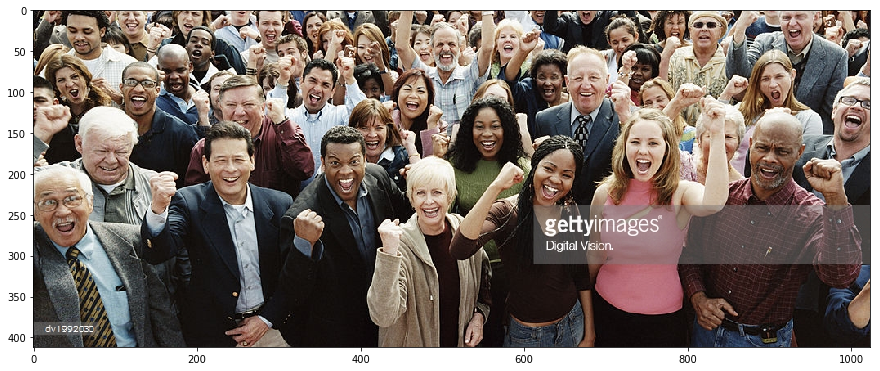

In [13]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/crowd.jpg', short=512)
viz.plot_image(img)
plt.show()

There are 51 people in this photo.


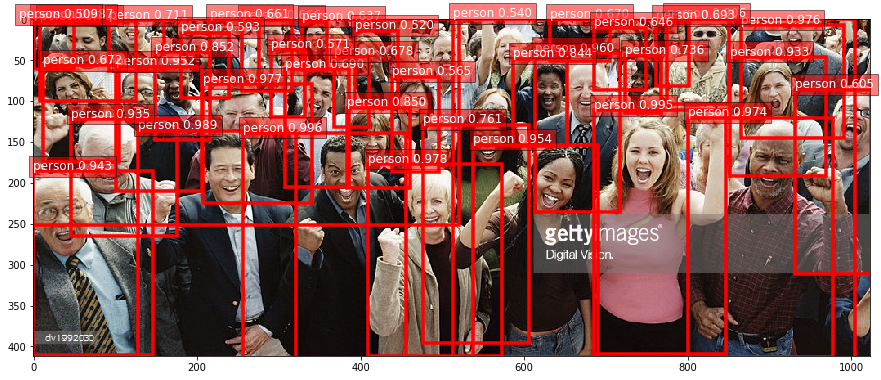

In [17]:
class_IDs, scores, bounding_boxes = net(x.as_in_context(mx.gpu(1)))
person_ind = [i for i, cls in enumerate(net.classes) if cls == 'person']
ind = np.nonzero(class_IDs[0].asnumpy() == person_ind)[0]

new_class_IDs = class_IDs[0][ind]
new_scores = scores[0][ind]
new_bounding_boxes = bounding_boxes[0][ind]

viz.plot_bbox(img, new_bounding_boxes, new_scores, new_class_IDs, class_names=net.classes)

print('There are %d people in this photo.'%(len(ind)))

Another scenario, following the heating topic: automated driving.

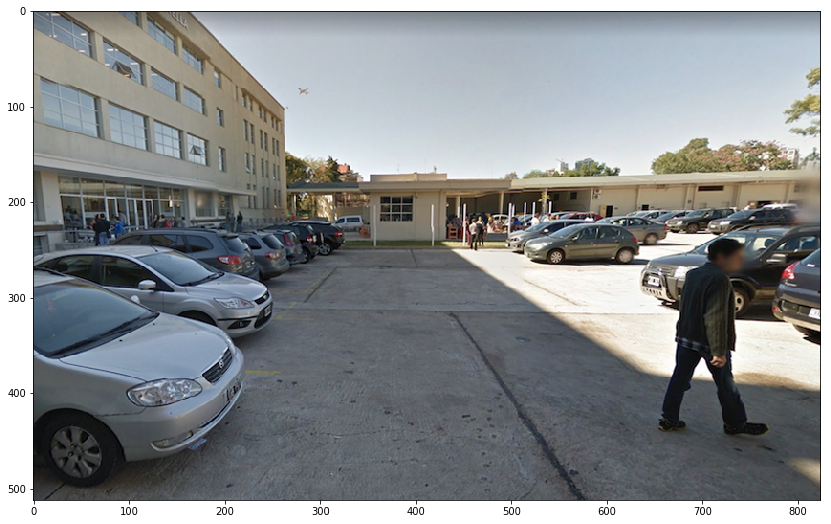

In [19]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/road1.jpg', short=512)
viz.plot_image(img)
plt.show()

In [16]:
%%time
class_IDs, scores, bounding_boxs = net(x.as_in_context(ctx))

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 26.8 ms


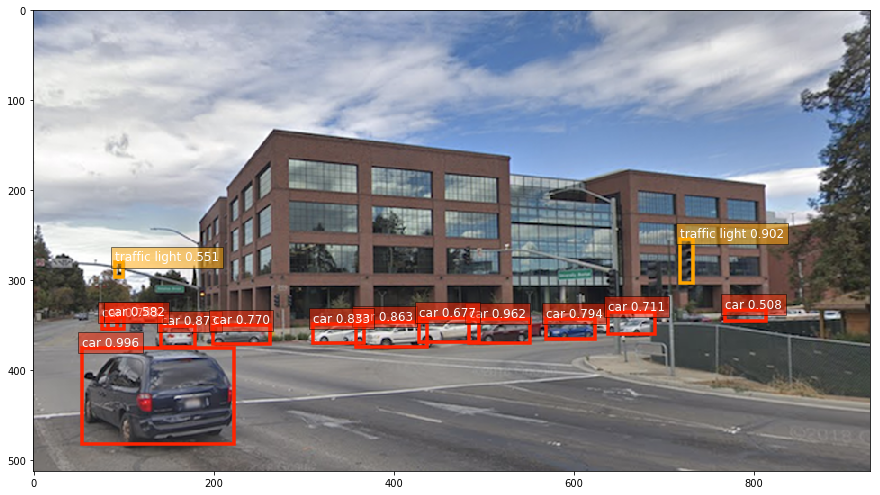

In [17]:
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

# Semantic Segmentation

Semantic segmentation takes the concept further, by predicting the class for every pixel.

In [20]:
ctx = mx.gpu(2)
net = get_model('fcn_resnet50_ade', pretrained=True, ctx=ctx)

Model file is not found. Downloading.


57418KB [00:01, 50702.16KB/s]                           


Model file is not found. Downloading.


128832KB [00:02, 44529.60KB/s]                            


In [21]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

CPU times: user 149 ms, sys: 942 ms, total: 1.09 s
Wall time: 7.98 s


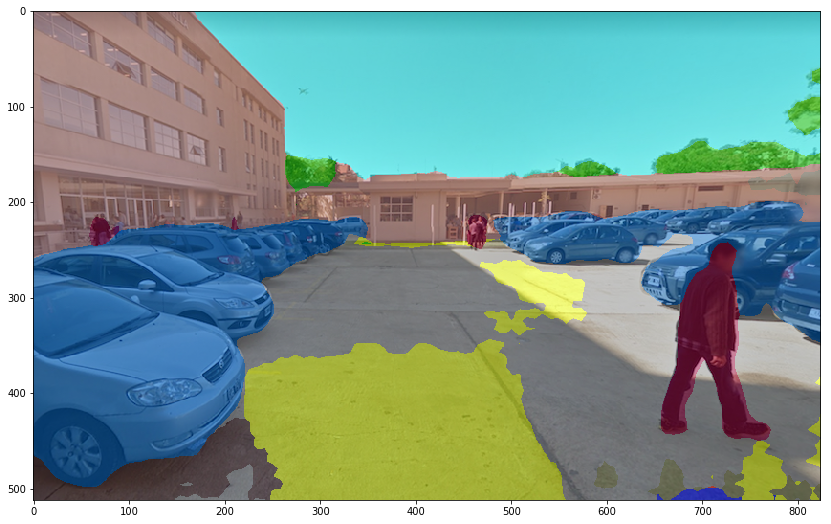

In [23]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2

plt.imshow(combined.astype(np.uint8))
plt.show()

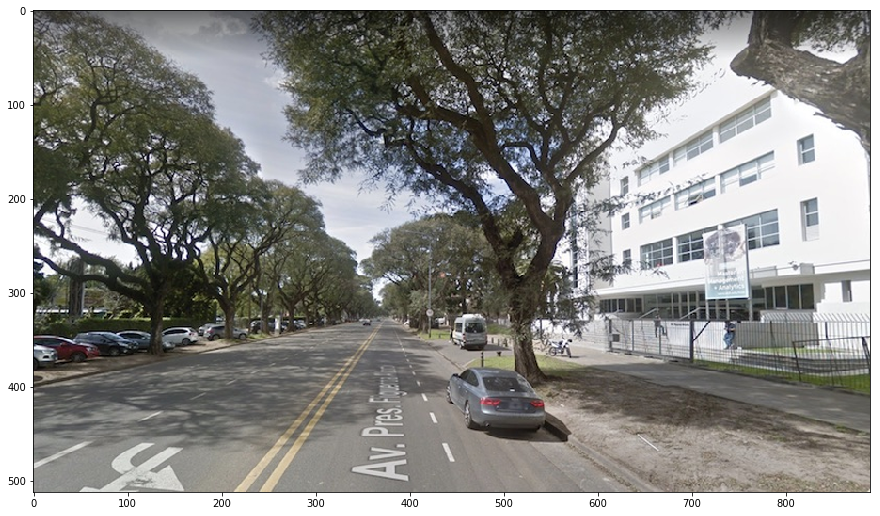

In [24]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/road2.jpg', short=512)
viz.plot_image(img)
plt.show()

In [25]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

CPU times: user 107 ms, sys: 1.57 s, total: 1.68 s
Wall time: 8.34 s


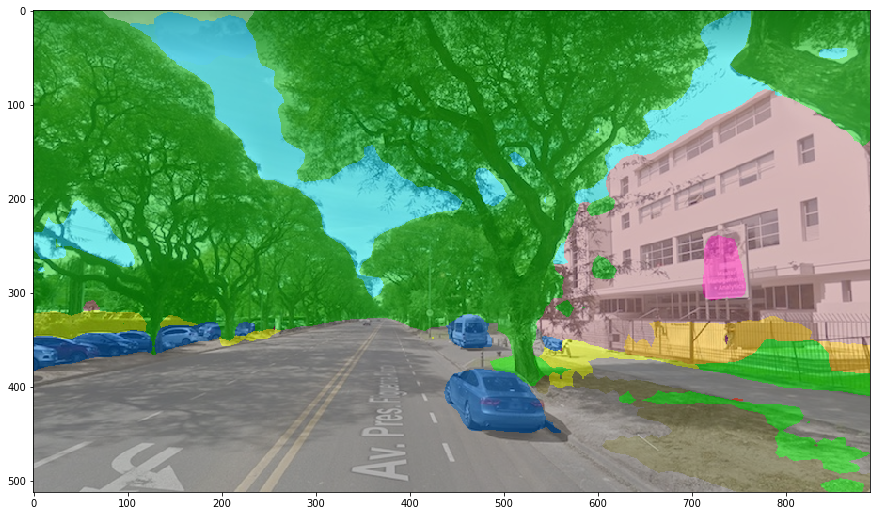

In [26]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2
plt.imshow(combined.astype(np.uint8))
plt.show()